In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

In [3]:
df = pd.read_excel("/content/drive/MyDrive/Hugo's Portfolio/Introducing NBEATSx to Realized Volatility Forecasting (Research)/NASDAQ Realized Volatility.xlsx",index_col='Date',parse_dates=True)


In [4]:
df.head()

,Realised,VIX
Date,,
2000-01-03,0.037159,27.010000
2000-01-04,0.036702,26.410000
2000-01-05,0.024682,25.730000
2000-01-06,0.017764,21.719999
2000-01-07,0.035145,21.709999


In [5]:
df_train=df[:int(len(df["Realised"])*0.7)]

Text(0, 0.5, 'Realized Volatility')

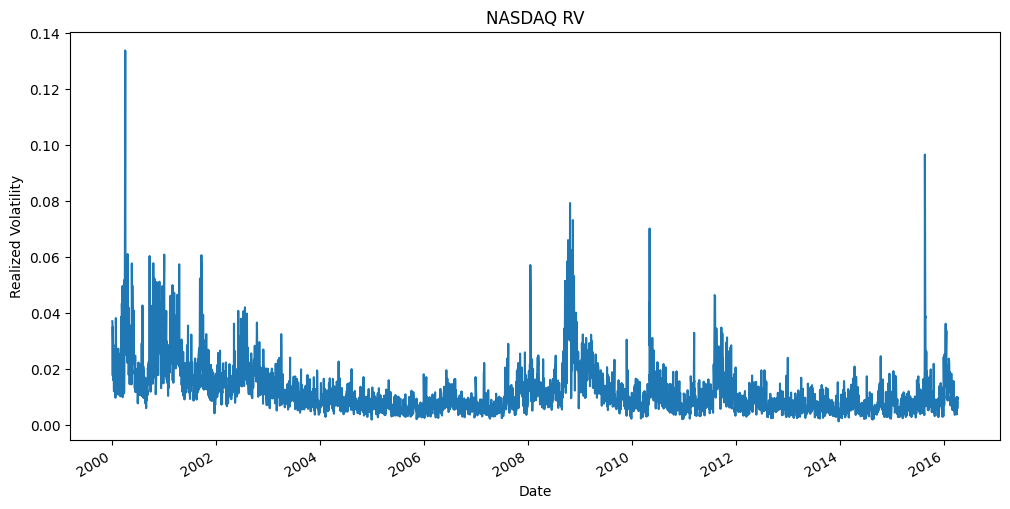

In [6]:
df_train["Realised"].plot(figsize=(12,6))
plt.title("NASDAQ RV")
plt.xlabel("Date")
plt.ylabel("Realized Volatility")

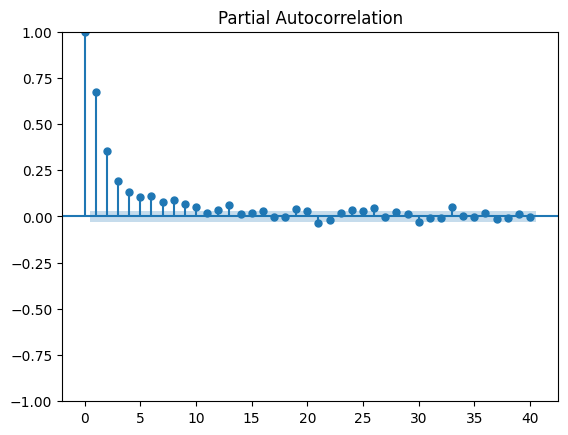

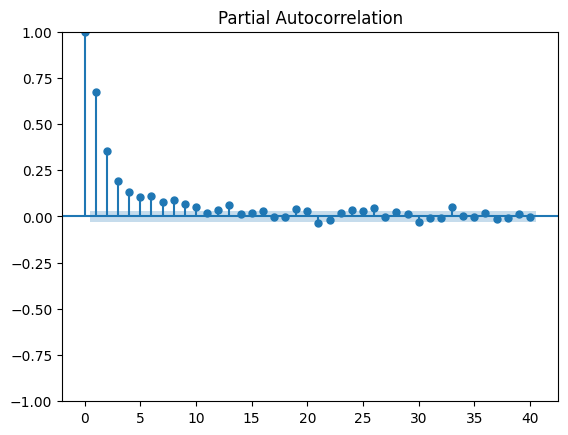

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_train["Realised"], lags = 40, method = "ols")

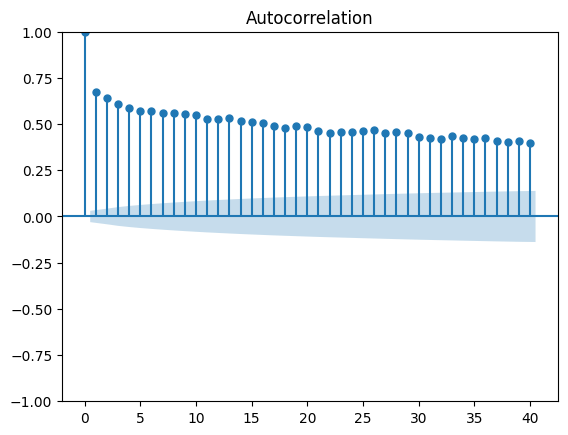

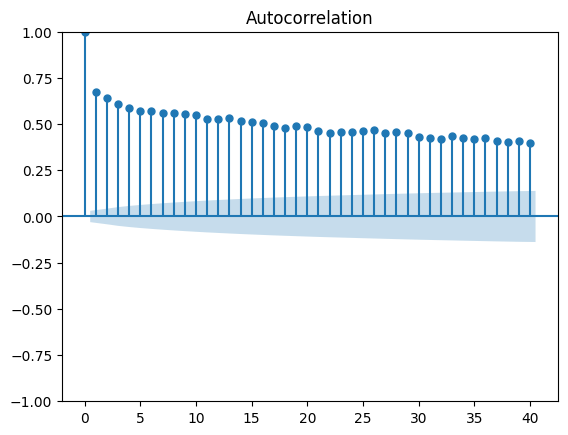

In [8]:
plot_acf(df_train["Realised"], lags = 40) 

Augmented Dickey Fuller test

In [9]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_train["Realised"])

(-4.608263306330276,
 0.00012471468038324074,
 25,
 4066,
 {'1%': -3.431959304767929,
  '5%': -2.8622511027398345,
  '10%': -2.56714852701696},
 -30313.620279252333)

In [10]:
len(df_train["Realised"])

4092

Breusch Godfrey test

In [22]:
df_for_Breusch_Godfrey_test = df_train.reset_index(drop=True)

In [23]:
import statsmodels.api as sm
y = df_for_Breusch_Godfrey_test["Realised"]
x = df_for_Breusch_Godfrey_test[['Realised']][:len(df_train["Realised"])-1]

In [24]:
for i in range(len(y)-1):
    y[i]=y[i+1]

In [25]:
y=y[:len(df_train["Realised"])-1]

In [26]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()

In [27]:
import statsmodels.stats.diagnostic as dg

In [28]:
print(dg.acorr_breusch_godfrey(model, nlags=10))

(798.8875163296117, 3.5789132769644017e-165, 99.93865129053337, 8.727832569983022e-186)


Ljung-Box Test

In [29]:
def sac(x, k=1):
    """
    ----------
    x : 1d numpy array
        Signal
    k : int or list of ints
        Lags to calculate sample autocorrelation for
    Returns
    -------
    res : scalar or np array
        The sample autocorrelation. A scalar value if k is a scalar, and a
        numpy array if k is a interable.
    """
    try:
        res = []
        for ki in k:
            res.append(sac(x, ki))
        return np.array(res)
    except:
        pass
    mx = np.mean(x)
    if k==0:
        N = np.sum((x-mx)*(x-mx))
    else:
        N = np.sum((x[:-k]-mx)*(x[k:]-mx))
    D = len(x) * np.var(x)
    return N/D


def ljungbox(x, lags, alpha=0.1):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2) / (n-k)
    Q = n*(n+2)*Q
    return Q

def boxpierce(x, lags, alpha=0.1):
    """
    The Box-Pierce test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : int
        Number of lags being tested
       
    Returns
    -------
    Q : float
        Test statistic
    """
    n = len(x)
    Q = 0
    for k in range(1, lags+1):
        Q += (sac(x, k)**2)
    Q = n*Q
    return Q

def lbqtest(x, lags, alpha=0.1, method='lb'):
    """
    The Ljung-Box test for determining if the data is independently distributed.
    Parameters
    ----------
    x : 1d numpy array
        Signal to test
    lags : list of ints
        Lags being tested
    alpha : float
        Significance level used for the tests
    method : string
        Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce
       
    Returns
    -------
    h : np array
        Numpy array of bool values, True == H0 hypothesis rejected
    pV : np array
        Test statistics p-values
    Q : np array
        Test statistics
    cV : np array
        Critical values used for determining if H0 should be rejected. The
        critical values are calculated from the given alpha and lag.
    """
    if method=='lb':
        findq = ljungbox
    else:
        findq = boxpierce
    n = len(x)
    Q = np.zeros(len(lags))
    pV = np.zeros(len(lags))
    cV = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        Q[i] = findq(x, lag)
        pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
        cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
    h = Q>cV
    return h, pV, Q, cV

In [30]:
h, pV, Q, cV = lbqtest(y, range(1, 25), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000   4078.120      2.706      True
2       0.000   8152.999      4.605      True
3       0.000  12227.897      6.251      True
4       0.000  16289.082      7.779      True
5       0.000  20348.020      9.236      True
6       0.000  24405.835     10.645      True
7       0.000  28460.333     12.017      True
8       0.000  32510.804     13.362      True
9       0.000  36561.890     14.684      True
10      0.000  40613.791     15.987      True
11      0.000  44663.937     17.275      True
12      0.000  48713.270     18.549      True
13      0.000  52758.253     19.812      True
14      0.000  56797.798     21.064      True
15      0.000  60836.460     22.307      True
16      0.000  64867.654     23.542      True
17      0.000  68892.514     24.769      True
18      0.000  72899.972     25.989      True
19      0.000  76904.758     27.204      True
20      0.000  80909.249     28.412      True
21      0.000  84911.036     29.6

In [31]:
from pandas.plotting import lag_plot

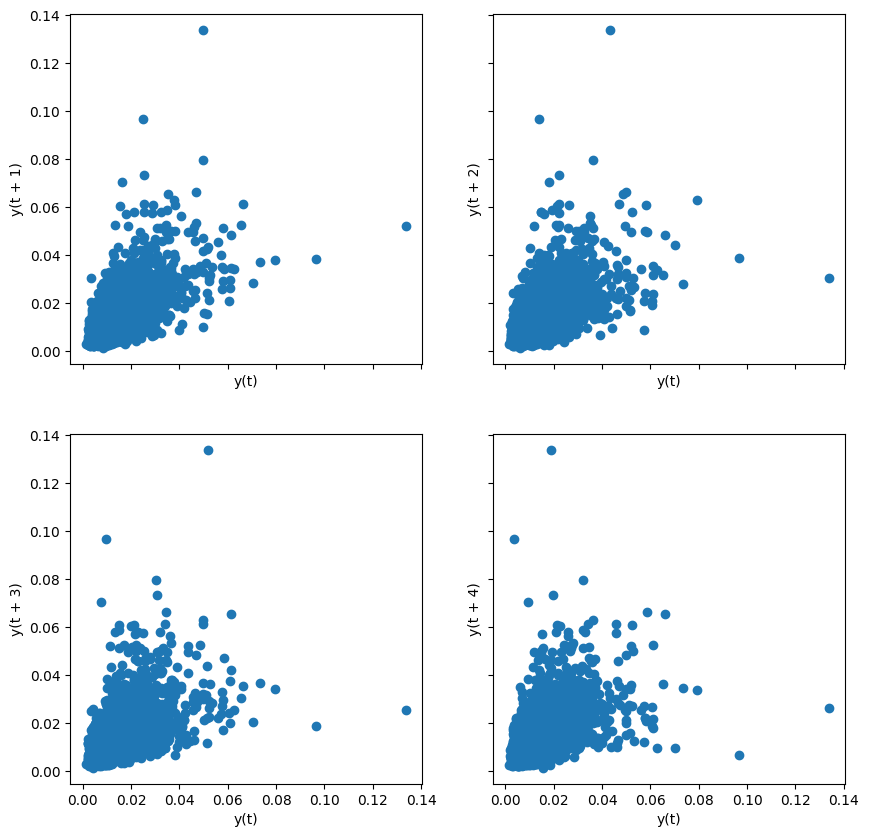

In [21]:
plot_lags = 10
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df_train["Realised"], lag=count, ax=axes[i, j])
        count+=1